In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt


In [21]:
# Define the start and end date for the data
start = datetime(2008, 1, 1)
end = datetime(2017, 12, 31)

# Define the stock symbol (e.g., Apple Inc.)
stock_symbol = 'AAPL'  # You can change this to any stock ticker you want

# Fetch the stock data using yfinance
stock_data = yf.download(stock_symbol, start=start, end=end)

# Display the first few rows to check the data
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.876340,1079178800
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.879056,842066400
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.430279,1455832000
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.357591,2072193200
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.164870,1523816000


In [4]:
# Display the last few rows of the stock data
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908981,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974495,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342972,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.316292,146266000
2019-12-30,72.364998,73.172501,71.305000,72.879997,70.733604,144114400


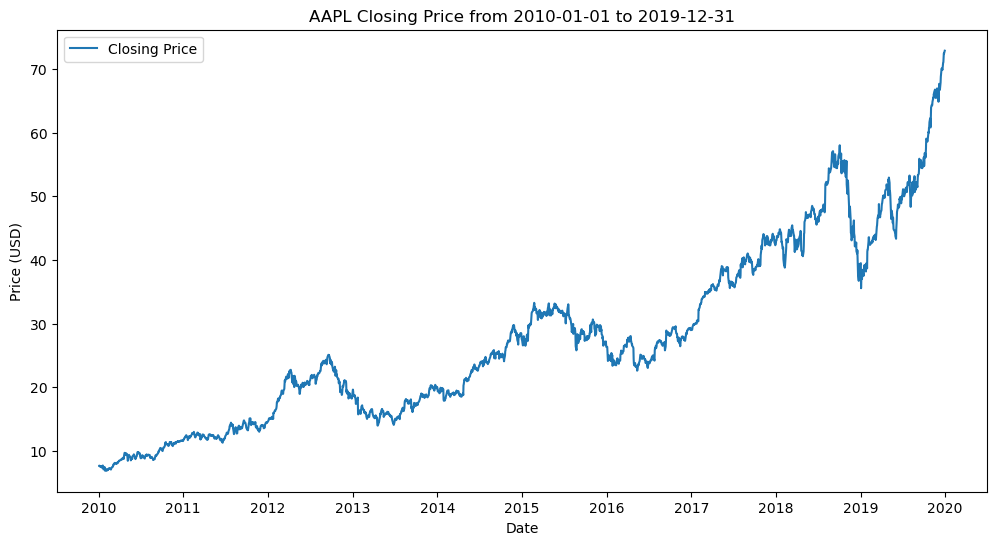

In [12]:

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price')
plt.title(f'{stock_symbol} Closing Price from {start} to {end}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()



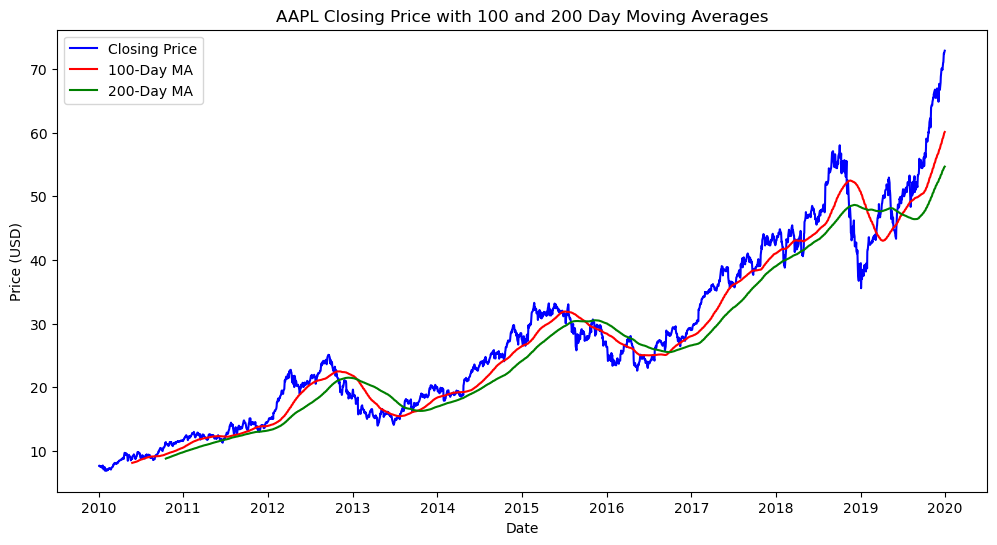

In [14]:


# Calculate the 100-day and 200-day moving averages
df['MA100'] = df['Close'].rolling(window=100).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Plot the Closing Price and Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['MA100'], label='100-Day MA', color='red')
plt.plot(df['MA200'], label='200-Day MA', color='green')
plt.title(f'{stock_symbol} Closing Price with 100 and 200 Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [15]:
# Step: Splitting Data into Training and Testing Sets (70% Training, 30% Testing)
train_size = int(len(df) * 0.70)  # 70% for training
data_training = df['Close'][:train_size]  # Training data
data_testing = df['Close'][train_size:]   # Testing data

# Display the sizes of the training and testing sets
print(f'Training data size: {len(data_training)}')
print(f'Testing data size: {len(data_testing)}')


Training data size: 1760
Testing data size: 755


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Step: Scaling the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_scaled = scaler.fit_transform(data_training.values.reshape(-1, 1))  # Reshape for scaling

# Display the first few scaled training values
print(data_training_scaled[:5])


[[0.02971782]
 [0.03021854]
 [0.02560389]
 [0.02507608]
 [0.02697067]]


In [17]:
# Prepare the training data for LSTM
X_train = []
y_train = []

# Create sequences for training data
for i in range(100, len(data_training_scaled)):
    X_train.append(data_training_scaled[i-100:i])  # Use 100 days as the input features
    y_train.append(data_training_scaled[i, 0])     # The target value is the closing price on day i

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Display the shapes of the training data
print(X_train.shape)
print(y_train.shape)


(1660, 100, 1)
(1660,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

# Define the LSTM model
model = Sequential()

# Input layer with 50 units
model.add(Input(shape=(X_train.shape[1], 1)))  # Timesteps = 100, Features = 1

# First LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(units=1))  # Predicting the closing price

# Model Summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Ensure 'Close' column is used for training
data_training = df['Close'][0:int(len(df) * 0.70)].values.reshape(-1, 1)  # Reshape to 2D

# Now, scale using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)  # Scale the training data

# Define x_train and y_train
x_train = []
y_train = []

for i in range(100, len(data_training_array)):
    x_train.append(data_training_array[i-100:i])  # Past 100 days
    y_train.append(data_training_array[i, 0])      # Target value is the closing price

# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0729 - val_loss: 0.0021
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0064 - val_loss: 0.0109
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0071 - val_loss: 0.0026
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0

In [29]:
# Save the trained model
model.save('keras_model.h5')


In [30]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('keras_model.h5')


In [33]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data_training' is your NumPy array
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)  # Scale the training data

# Prepare the training data
x_train = []
y_train = []
for i in range(100, len(data_training_array)):
    x_train.append(data_training_array[i-100:i])  # Use the past 100 days
    y_train.append(data_training_array[i, 0])      # The target value is the closing price

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape y_train to be 2D (required for the model)
y_train = y_train.reshape(-1, 1)


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your DataFrame containing the entire dataset
train_size = int(len(df) * 0.8)  # 80% for training
data_training = df[:train_size]
data_testing = df[train_size:]  # Remaining 20% for testing

# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training[['Close']].values)

# Prepare the training data
x_train = []
y_train = []
for i in range(100, len(data_training_array)):
    x_train.append(data_training_array[i-100:i])  # Use the past 100 days
    y_train.append(data_training_array[i, 0])      # The target value is the closing price

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1, 1)  # Reshape y_train to be 2D

# Prepare the testing data
data_testing_array = data_testing[['Close']].values  # Use only the 'Close' prices
inputs = scaler.transform(data_testing_array)  # Scale the testing data

# Create the test sequences
x_test = []
for i in range(100, inputs.shape[0]):
    x_test.append(inputs[i-100:i])

# Convert to numpy array
x_test = np.array(x_test)

# Ensure x_test is 3D
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)  # Add feature dimension




13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


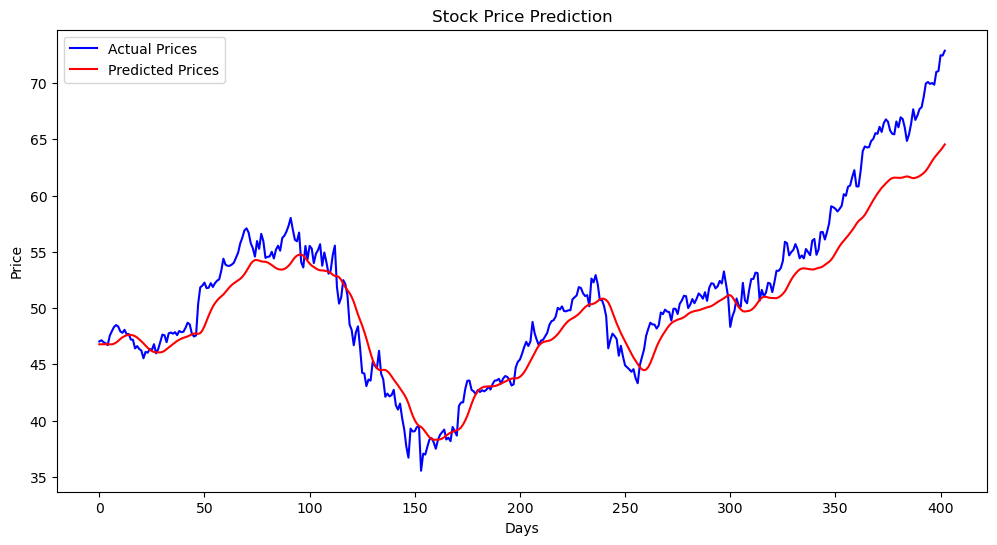

In [39]:
# Assuming you have already trained your model and have x_test ready
predictions = model.predict(x_test)

# Inverse scale the predictions to get them back to original values
predictions = scaler.inverse_transform(predictions)

# Get the actual closing prices from the data_testing DataFrame
actual_prices = data_testing['Close'].values[100:]  # Skip the first 100 entries

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
